# RankEM Data Analysis Workflow

This notebook breaks down the workflow from `run_real_data.py` into logical chunks, allowing for interactive inspection of the data, the estimation process, and the results.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from estimator import Estimator

%matplotlib inline
sns.set_style('whitegrid')

## 1. Load Data

We search for the raw CSV data file in the `data/` directory and load it.

In [3]:
def load_csv_data(filepath):
    """Load score matrix from CSV file."""
    df = pd.read_csv(filepath, header=None, na_values=['', ' '])
    row_labels = df.iloc[:, 0].astype(str).tolist()
    X = df.iloc[:, 1:].values.astype(float)
    return row_labels, X

data_dir = Path('data/Y9 update2')
csv_file = data_dir / 'input.csv'

print(f"Loading data from: {csv_file}")

row_labels, X = load_csv_data(str(csv_file))
print(f"Data shape: {X.shape} (students × problems)")

Loading data from: data\ORAL ASSESSMENT Y9 ALL.csv
Data shape: (43, 24) (students × problems)


## 2. Missing Data Analysis

Before running estimators, it's crucial to understand the missing data pattern.

Missing rate: 34.88%


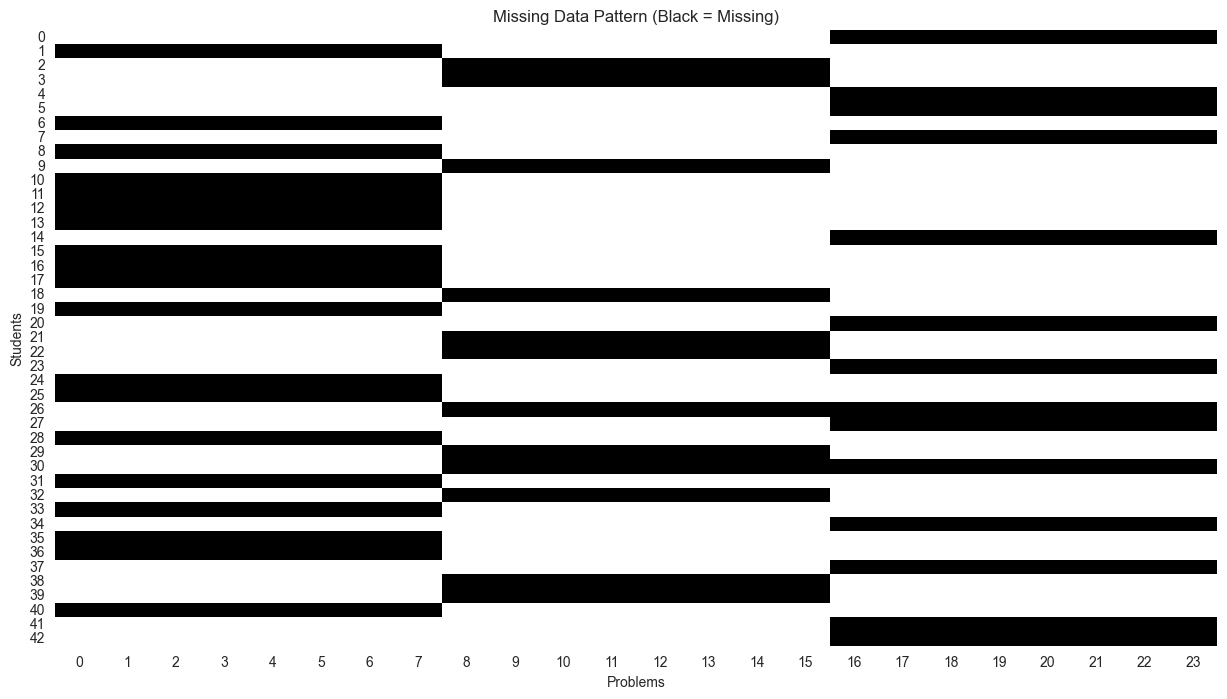

In [4]:
def compute_missing_stats(X):
    n_students, n_problems = X.shape
    total_cells = n_students * n_problems
    missing_mask = np.isnan(X)
    n_missing = np.sum(missing_mask)
    
    missing_per_student = np.sum(missing_mask, axis=1)
    missing_per_problem = np.sum(missing_mask, axis=0)
    
    return {
        'n_students': n_students,
        'n_problems': n_problems,
        'total_cells': total_cells,
        'n_missing': n_missing,
        'missing_rate': n_missing / total_cells,
        'missing_per_student': missing_per_student,
        'missing_per_problem': missing_per_problem
    }

stats = compute_missing_stats(X)
print(f"Missing rate: {stats['missing_rate']:.2%}")

# Visualizing missing data
plt.figure(figsize=(15, 8))
sns.heatmap(np.isnan(X), cbar=False, cmap='binary')
plt.title('Missing Data Pattern (Black = Missing)')
plt.xlabel('Problems')
plt.ylabel('Students')
plt.show()

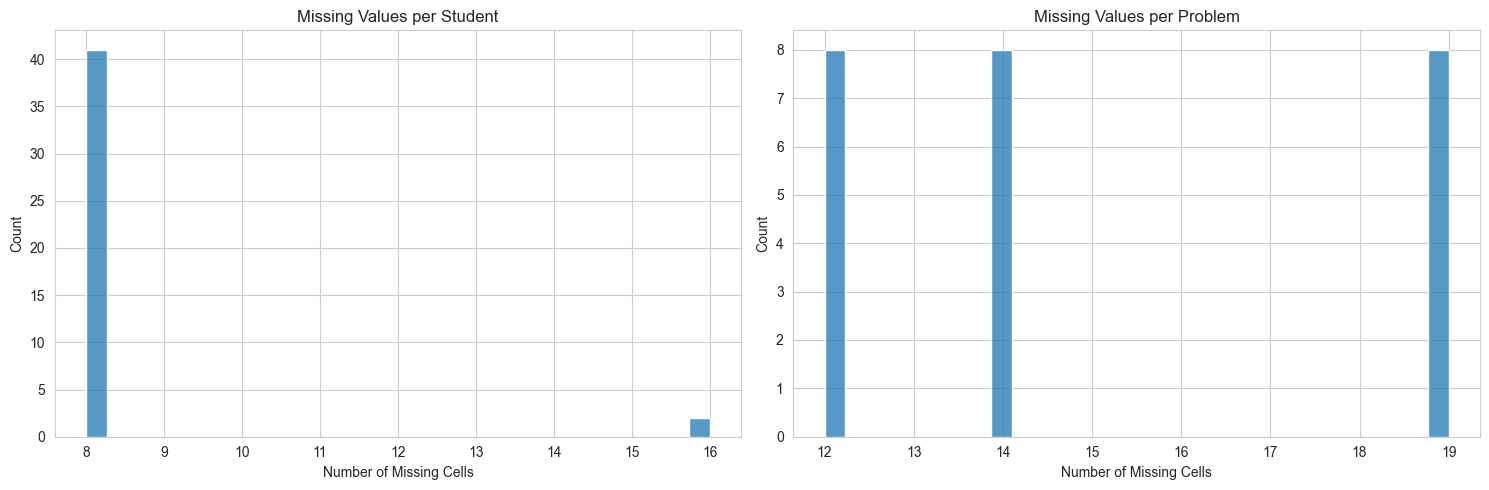

In [5]:
# Distribution of missingness
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(stats['missing_per_student'], ax=ax1, bins=30)
ax1.set_title('Missing Values per Student')
ax1.set_xlabel('Number of Missing Cells')

sns.histplot(stats['missing_per_problem'], ax=ax2, bins=30)
ax2.set_title('Missing Values per Problem')
ax2.set_xlabel('Number of Missing Cells')

plt.tight_layout()
plt.show()

## 3. Run Estimators

We will run three different estimation methods:
1. **EM Estimator**: Regularized Expectation-Maximization.
2. **Mean Imputation**: A simple heuristic using row and column means.
3. **Day Average**: A heuristic that assumes block-wise structure (days).

In [6]:
results = {}

min_mark, max_mark = 0., 6.
print(f"Using explicit clipping range: [{min_mark}, {max_mark}]")

# 1. EM Estimator
print("Running EM Estimator...")
em_est = Estimator.em(X, lambda_theta=1.0, lambda_beta=1.0, min_mark=min_mark, max_mark=max_mark)
results['EM Estimator'] = em_est
print(f"  Converged in {em_est.n_iterations} iterations")
print(f"  σ(ε) = {em_est.sigma_epsilon:.4f}")

# 2. Mean Imputation
print("\nRunning Mean Imputation...")
imp_est = Estimator.mean_imputation(X, min_mark=min_mark, max_mark=max_mark)
results['Mean Imputation'] = imp_est
print(f"  σ(ε) = {imp_est.sigma_epsilon:.4f}")

# 3. Day Average
print("\nRunning Day Average...")
day_est = Estimator.day_average(X, n_blocks=3, min_mark=min_mark, max_mark=max_mark)
results['Day Average'] = day_est
print(f"  σ(ε) = {day_est.sigma_epsilon:.4f}")

Running EM Estimator...
  Converged in 59 iterations
  σ(ε) = 1.7919

Running Mean Imputation...
  σ(ε) = 1.8330

Running Day Average...
  σ(ε) = 2.0153


## 4. Compare Results

Let's compare the methods based on the standard deviation of residuals (noise level) and the spread of estimated parameters.

In [7]:
summary_data = []
for name, est in results.items():
    summary_data.append({
        'Method': name,
        'σ(ε)': est.sigma_epsilon,
        'Std(θ)': est.std_theta,
        'Std(β)': est.std_beta,
        'Iterations': est.n_iterations
    })

summary_df = pd.DataFrame(summary_data).set_index('Method')
display(summary_df)

,σ(ε),Std(θ),Std(β),Iterations
Method,,,,
EM Estimator,1.791907,1.340943,1.310902,59.0
Mean Imputation,1.833015,1.370345,1.249822,NaN
Day Average,2.015297,1.405807,0.812781,NaN


## 5. Detailed Analysis

### Student Abilities (θ)

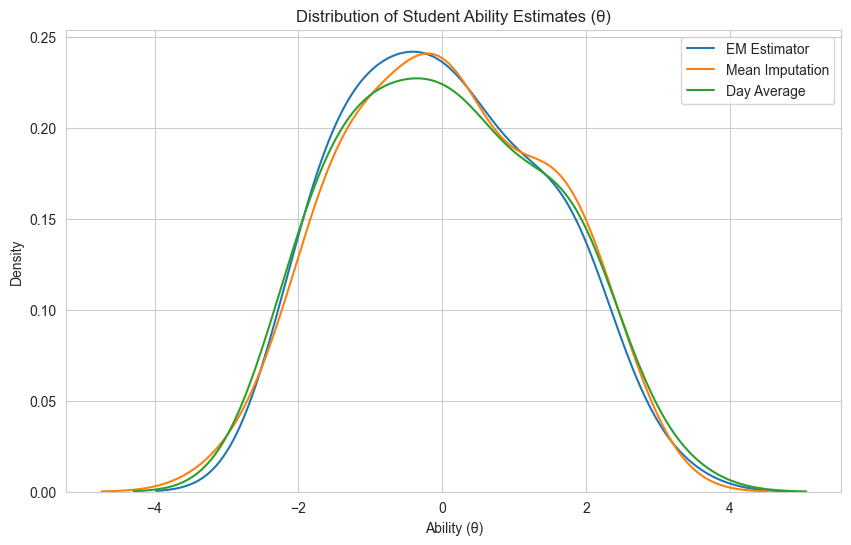

In [8]:
# Plot distribution of theta estimates
plt.figure(figsize=(10, 6))
for name, est in results.items():
    sns.kdeplot(est.theta, label=name)

plt.title('Distribution of Student Ability Estimates (θ)')
plt.xlabel('Ability (θ)')
plt.ylabel('Density')
plt.legend()
plt.show()

In [15]:
for _,res in results.items():
    print(res.theta[4:6]) 

[2.03781554 2.03781554]
[1.57589286 1.57589286]
[2.07064852 2.07064852]


In [10]:
X[4:6,:]

array([[ 6.,  6.,  5.,  6.,  6.,  3.,  4.,  5.,  0.,  6.,  4.,  6.,  6.,
         4.,  6.,  5., nan, nan, nan, nan, nan, nan, nan, nan],
       [ 6.,  6.,  4.,  3.,  6.,  4.,  4.,  6.,  4.,  6.,  4.,  6.,  3.,
         6.,  6.,  4., nan, nan, nan, nan, nan, nan, nan, nan]])

In [ ]:
# Scatter plot comparing two methods (e.g., EM vs Mean Imputation)
plt.figure(figsize=(8, 8))
plt.scatter(results['Mean Imputation'].theta, results['EM Estimator'].theta, alpha=0.5)
plt.plot([-3, 3], [-3, 3], 'r--')  # y=x line
plt.title('Student Ability: EM vs Mean Imputation')
plt.xlabel('Mean Imputation θ')
plt.ylabel('EM Estimator θ')
plt.show()

In [ ]:
# Top and Bottom Students (using EM)
est = results['EM Estimator']
sorted_idx = np.argsort(est.theta)

print("Top 5 Students:")
for idx in sorted_idx[-5:][::-1]:
    print(f"Student {idx+1}: θ = {est.theta[idx]:.3f}")

print("\nBottom 5 Students:")
for idx in sorted_idx[:5]:
    print(f"Student {idx+1}: θ = {est.theta[idx]:.3f}")

### Problem Difficulties (β)

In [ ]:
# Plot distribution of beta estimates
plt.figure(figsize=(10, 6))
for name, est in results.items():
    sns.kdeplot(est.beta, label=name)

plt.title('Distribution of Problem Difficulty Estimates (β)')
plt.xlabel('Difficulty (β) [Higher = Easier]')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
# Hardest and Easiest Problems (using EM)
est = results['EM Estimator']
sorted_idx = np.argsort(est.beta)

print("Easiest 5 Problems (Highest β):")
for idx in sorted_idx[-5:][::-1]:
    print(f"Problem {idx+1}: β = {est.beta[idx]:.3f}")

print("\nHardest 5 Problems (Lowest β):")
for idx in sorted_idx[:5]:
    print(f"Problem {idx+1}: β = {est.beta[idx]:.3f}")

## 6. Save Consolidated Results

Finally, we save the estimates to CSV files for further processing.

In [ ]:
# Save Theta
theta_data = {'student_id': range(1, len(X) + 1)}
for method_name, est in results.items():
    col_name = method_name.lower().replace(' ', '_')
    theta_data[col_name] = est.theta
    
theta_df = pd.DataFrame(theta_data)
theta_file = data_dir / 'theta_all_methods.csv'
theta_df.to_csv(theta_file, index=False)
print(f"Saved theta estimates to: {theta_file}")

# Save Beta
beta_data = {'problem_id': range(1, X.shape[1] + 1)}
for method_name, est in results.items():
    col_name = method_name.lower().replace(' ', '_')
    beta_data[col_name] = est.beta

beta_df = pd.DataFrame(beta_data)
beta_file = data_dir / 'beta_all_methods.csv'
beta_df.to_csv(beta_file, index=False)
print(f"Saved beta estimates to: {beta_file}")